<a href="https://colab.research.google.com/github/IKnigencev/Deep-Learning-example/blob/main/CarCassification%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознование марки машин

---

*   Ferrari
*   Mercedes
*   Renault

Датасет взят с платного курса.





## Подключение бибилиотек и загрузка базы данных автомобилей


In [1]:
# Импорт всех необходимых библиотек 
import numpy as np                                                                                  

from tensorflow.keras import utils

from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications import Xception

import tensorflow as tf

import keras

from PIL import Image         

import numpy as np   

import os

import gc

import matplotlib.pyplot as plt

%matplotlib inline

## Утилиты

In [12]:
def get_predict_test_show_result_epochs(model, test, history):
  # Вывод результата на тестовых данных + визуализация результата обучения

  scores = model.evaluate(test)

  print('-'*100)

  print(f'Резльтата распознования на тестовых данных: {round(scores[1],2) * 100} %')

  print('-'*100)

  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.show()

## Глобальные переменные 

In [2]:
# Определение основных переменных 
TRAIN_PATH          = '/content/cars'       
TEST_PATH           = '/content/cars_test'  

TEST_SPLIT          = 0.1                   
VAL_SPLIT           = 0.2                 

IMG_WIDTH           = 256                   
IMG_HEIGHT          = 128                   
IMG_CHANNELS        = 3                     

ROTATION_RANGE      = 8                    
WIDTH_SHIFT_RANGE   = 0.15               
HEIGHT_SHIFT_RANGE  = 0.15                  
ZOOM_RANGE          = 0.15                 
BRIGHTNESS_RANGE    = (0.7, 1.3)            
HORIZONTAL_FLIP     = True      
CLASS_COUNT         = 3            

EPOCHS              = 80                 
BATCH_SIZE          = 24                

## Загрузка данных

In [3]:
# Загрузка датасета
import gdown
gdown.download(url, None, quiet=True)

'middle_fmr.zip'

In [4]:
# Распаковка датасета
!unzip -qo 'middle_fmr.zip' -d {TRAIN_PATH}

## Обработка данных

In [5]:
# Определение меток данных 
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

In [6]:
# Удаление тестовой папки для повторного запуска, если папка уже существует 
!rm -rf {TEST_PATH}

In [7]:
# Распределение фотографий на папки для тренировчного и тестовых данных
os.mkdir(TEST_PATH)                                       
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [8]:
# Аугментация изобрений
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )


test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [9]:
# Загрузка данных в пермененные для тренировочного, валидационного и тестового набора данных
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,    
    subset="training",       
    seed=123,               
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,    
    seed=123,   
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation'
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    validation_split=0.2,    
    subset="validation",      
    seed=123,               
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3086 files belonging to 3 classes.
Using 2469 files for training.
Found 3086 files belonging to 3 classes.
Using 617 files for validation.
Found 341 files belonging to 3 classes.
Using 68 files for validation.


## Обучение модели

### EfficientNetB7

In [10]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
gc.collect()

base_model = tf.keras.applications.EfficientNetB7(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet')

input = tf.keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = preprocess_input(input)
x = base_model(x, training=True)
x  = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(input, output)

258088960/258076736 [==============================] - 7s 0us/step


In [11]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 256, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 4, 8, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 3)                 7683      
                                                                 
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
___________________________________________

Схема модели


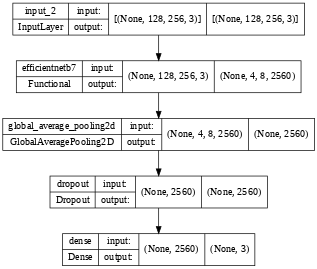

In [13]:
print('Схема модели')
utils.plot_model(model, show_shapes=True, dpi=50)

In [14]:
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs=10)

Epoch 1/10
103/103 [==============================] - 163s 1s/step - loss: 0.6094 - accuracy: 0.7639 - val_loss: 0.4540 - val_accuracy: 0.8509
Epoch 2/10
103/103 [==============================] - 101s 975ms/step - loss: 0.2792 - accuracy: 0.9040 - val_loss: 0.3458 - val_accuracy: 0.9060
Epoch 3/10
103/103 [==============================] - 100s 969ms/step - loss: 0.1694 - accuracy: 0.9405 - val_loss: 0.3563 - val_accuracy: 0.8979
Epoch 4/10
103/103 [==============================] - 101s 982ms/step - loss: 0.1450 - accuracy: 0.9538 - val_loss: 0.2540 - val_accuracy: 0.9109
Epoch 5/10
103/103 [==============================] - 100s 967ms/step - loss: 0.0891 - accuracy: 0.9729 - val_loss: 0.3090 - val_accuracy: 0.9076
Epoch 6/10
103/103 [==============================] - 100s 971ms/step - loss: 0.0830 - accuracy: 0.9729 - val_loss: 0.2916 - val_accuracy: 0.9092
Epoch 7/10
103/103 [==============================] - 101s 975ms/step - loss: 0.0717 - accuracy: 0.9729 - val_loss: 0.2356 - va

3/3 [==============================] - 2s 695ms/step - loss: 0.2845 - accuracy: 0.9265
----------------------------------------------------------------------------------------------------
Резльтата распознования на тестовых данных: 93.0 %
----------------------------------------------------------------------------------------------------


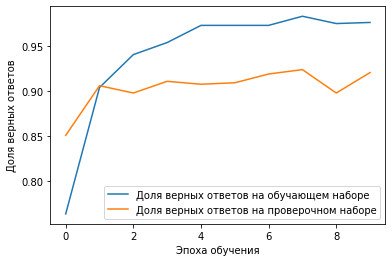

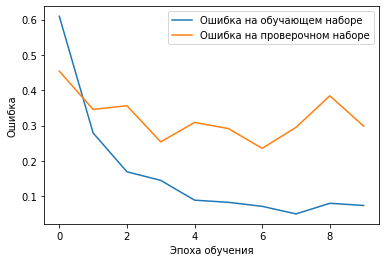

In [15]:
get_predict_test_show_result_epochs(model, test_generator, history)

In [ ]:
# Подключение к гугл диску для сохранения модели
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Сохранение модели
model.save('drive/MyDrive/model/EfficientNetB7car.h5')

### EfficientNetV2L

In [31]:
preprocess = tf.keras.applications.efficientnet_v2.preprocess_input
gc.collect()

base_model = tf.keras.applications.EfficientNetV2L(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet')

input_img = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = preprocess(input_img)
x = base_model(x, training=True)
x  = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

model_V2L = tf.keras.Model(input_img, output)

In [32]:
model_V2L.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

print(model_V2L.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 256, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 4, 8, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 117,750,691
Trainable params: 117,238,115
Non

Схема модели


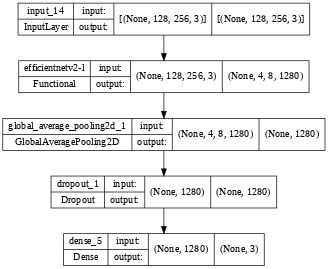

In [36]:
print('Схема модели')
utils.plot_model(model_V2L, show_shapes=True, dpi=50)

In [33]:
history_V2L = model_V2L.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs=10)

Epoch 1/10
103/103 [==============================] - 134s 916ms/step - loss: 0.6362 - accuracy: 0.7319 - val_loss: 0.3777 - val_accuracy: 0.8752
Epoch 2/10
103/103 [==============================] - 87s 847ms/step - loss: 0.2875 - accuracy: 0.9028 - val_loss: 0.3069 - val_accuracy: 0.8947
Epoch 3/10
103/103 [==============================] - 87s 845ms/step - loss: 0.2126 - accuracy: 0.9271 - val_loss: 0.3874 - val_accuracy: 0.8574
Epoch 4/10
103/103 [==============================] - 86s 838ms/step - loss: 0.1375 - accuracy: 0.9542 - val_loss: 0.4094 - val_accuracy: 0.8655
Epoch 5/10
103/103 [==============================] - 86s 829ms/step - loss: 0.1387 - accuracy: 0.9571 - val_loss: 0.3179 - val_accuracy: 0.8882
Epoch 6/10
103/103 [==============================] - 86s 835ms/step - loss: 0.1113 - accuracy: 0.9607 - val_loss: 0.3434 - val_accuracy: 0.8963
Epoch 7/10
103/103 [==============================] - 85s 823ms/step - loss: 0.1068 - accuracy: 0.9595 - val_loss: 0.3131 - val_a

3/3 [==============================] - 1s 532ms/step - loss: 0.2761 - accuracy: 0.8971
----------------------------------------------------------------------------------------------------
Резльтата распознования на тестовых данных: 90.0 %
----------------------------------------------------------------------------------------------------


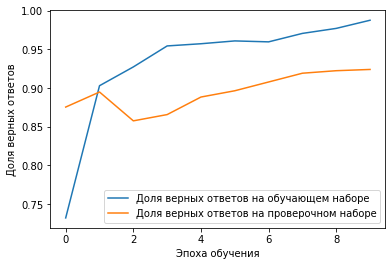

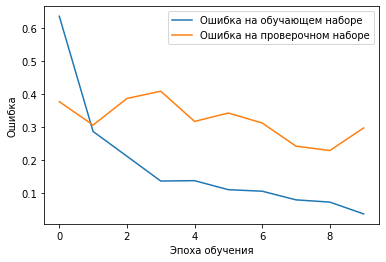

In [34]:
get_predict_test_show_result_epochs(model_V2L, test_generator, history_V2L)

### ResNet50V2

In [40]:
preproccess = tf.keras.applications.resnet_v2.preprocess_input
gc.collect()

base_model = tf.keras.applications.ResNet50V2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights="imagenet",
)

input_img = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = preproccess(input_img)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(3, activation='softmax')(x)

model_ResNet = tf.keras.Model(input_img, out)

In [42]:
model_ResNet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

print(model_ResNet.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 128, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 128, 256, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 4, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Схема модели


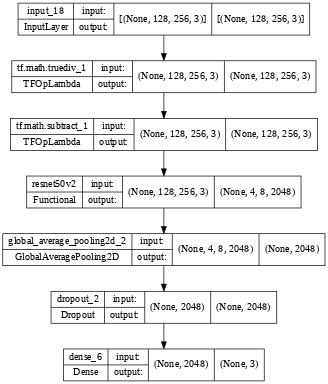

In [43]:
print('Схема модели')
utils.plot_model(model_ResNet, show_shapes=True, dpi=50)

In [44]:
history_RasNet = model_ResNet.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs=10)

Epoch 1/10
103/103 [==============================] - 28s 204ms/step - loss: 0.6578 - accuracy: 0.7161 - val_loss: 0.6261 - val_accuracy: 0.8136
Epoch 2/10
103/103 [==============================] - 18s 173ms/step - loss: 0.1293 - accuracy: 0.9623 - val_loss: 0.4652 - val_accuracy: 0.8687
Epoch 3/10
103/103 [==============================] - 18s 176ms/step - loss: 0.0323 - accuracy: 0.9943 - val_loss: 0.4330 - val_accuracy: 0.8736
Epoch 4/10
103/103 [==============================] - 18s 177ms/step - loss: 0.0224 - accuracy: 0.9935 - val_loss: 0.4629 - val_accuracy: 0.8703
Epoch 5/10
103/103 [==============================] - 18s 176ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 0.4672 - val_accuracy: 0.8736
Epoch 6/10
103/103 [==============================] - 18s 175ms/step - loss: 0.0429 - accuracy: 0.9846 - val_loss: 0.6269 - val_accuracy: 0.8331
Epoch 7/10
103/103 [==============================] - 19s 180ms/step - loss: 0.0982 - accuracy: 0.9635 - val_loss: 0.5672 - val_ac

3/3 [==============================] - 1s 399ms/step - loss: 0.3139 - accuracy: 0.9412
----------------------------------------------------------------------------------------------------
Резльтата распознования на тестовых данных: 94.0 %
----------------------------------------------------------------------------------------------------


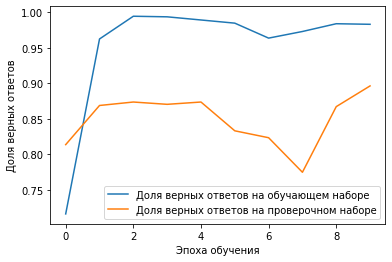

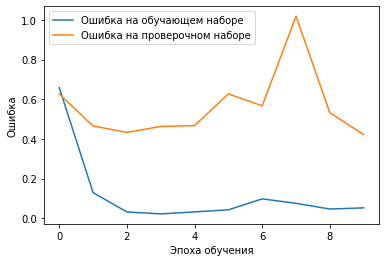

In [45]:
get_predict_test_show_result_epochs(model_ResNet, test_generator, history_RasNet)